In [ ]:
import zipfile
import os

zip_path = "/content/CASIA-Iris-Interval-20250617T034139Z-1-001.zip"  # Replace with your actual filename
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall("unzipped_Iris-Interval")

In [ ]:
import os
import shutil
import random

def get_all_images_recursive(class_path):
    images = []
    for root, _, files in os.walk(class_path):
        for file in files:
            if file.lower().endswith(('.jpg', '.jpeg', '.png')):
                images.append(os.path.join(root, file))
    return images

def split_dataset(input_dir, output_dir, train_ratio=0.625, val_ratio=0.25, test_ratio=0.125):
    # Set random seed for reproducibility
    random.seed(42)

    # Clear output directory to prevent duplicate images
    if os.path.exists(output_dir):
        shutil.rmtree(output_dir)
    os.makedirs(output_dir, exist_ok=True)

    class_names = os.listdir(input_dir)
    total_images = 0

    # Count total images across all classes
    for class_name in class_names:
        class_path = os.path.join(input_dir, class_name)
        if not os.path.isdir(class_path):
            continue
        images = get_all_images_recursive(class_path)
        total_images += len(images)
    print(f"Total images in input directory: {total_images}")

    # Split images for each class
    for class_name in class_names:
        class_path = os.path.join(input_dir, class_name)
        if not os.path.isdir(class_path):
            continue

        images = get_all_images_recursive(class_path)
        random.shuffle(images)

        total = len(images)
        train_end = int(train_ratio * total)
        val_end = train_end + int(val_ratio * total)

        train_imgs = images[:train_end]
        val_imgs = images[train_end:val_end]
        test_imgs = images[val_end:]

        for split_name, split_imgs in zip(['train', 'val', 'test'], [train_imgs, val_imgs, test_imgs]):
            split_dir = os.path.join(output_dir, split_name, class_name)
            os.makedirs(split_dir, exist_ok=True)
            for img_path in split_imgs:
                img_name = os.path.basename(img_path)
                dst = os.path.join(split_dir, img_name)
                shutil.copy2(img_path, dst)
            print(f"Copied {len(split_imgs)} images to {split_dir}")

input_dataset_folder = "/content/unzipped_Iris-Interval/CASIA-Iris-Interval"
output_dataset_folder = "/content/split_dataset"
split_dataset(input_dataset_folder, output_dataset_folder)

Total images in input directory: 2639
Copied 0 images to /content/split_dataset/train/180
Copied 0 images to /content/split_dataset/val/180
Copied 1 images to /content/split_dataset/test/180
Copied 4 images to /content/split_dataset/train/216
Copied 1 images to /content/split_dataset/val/216
Copied 2 images to /content/split_dataset/test/216
Copied 4 images to /content/split_dataset/train/212
Copied 1 images to /content/split_dataset/val/212
Copied 2 images to /content/split_dataset/test/212
Copied 5 images to /content/split_dataset/train/196
Copied 2 images to /content/split_dataset/val/196
Copied 2 images to /content/split_dataset/test/196
Copied 12 images to /content/split_dataset/train/020
Copied 5 images to /content/split_dataset/val/020
Copied 3 images to /content/split_dataset/test/020
Copied 4 images to /content/split_dataset/train/035
Copied 1 images to /content/split_dataset/val/035
Copied 2 images to /content/split_dataset/test/035
Copied 8 images to /content/split_dataset/t

In [ ]:
from tensorflow.keras.layers import Conv2D, Flatten, Dense, MaxPool2D, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model

import matplotlib.pyplot as plt
import numpy as np

In [ ]:
mg_height, img_width = (256,256)
batch_size = 16

train_data_dir = r"/content/split_dataset/train"
valid_data_dir = r"/content/split_dataset/val"
test_data_dir = r"/content/split_dataset/test"

In [ ]:
import os

def count_images_in_directory(directory):
    total = 0
    for root, dirs, files in os.walk(directory):
        for file in files:
            if file.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff')):
                total += 1
    return total



# Count and print
print(f" Number of training images: {count_images_in_directory(train_data_dir)}")
print(f" Number of validation images: {count_images_in_directory(valid_data_dir)}")
print(f" Number of test images: {count_images_in_directory(test_data_dir)}")

 Number of training images: 1533
 Number of validation images: 571
 Number of test images: 535


In [ ]:
train_datagen = ImageDataGenerator(dtype = 'float32', preprocessing_function=preprocess_input)
valid_datagen = ImageDataGenerator(dtype = 'float32', preprocessing_function=preprocess_input)

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(256, 256),
    batch_size=16,
    class_mode='categorical') # set as training data

valid_generator = valid_datagen.flow_from_directory(
    valid_data_dir,
    target_size=(256, 256),
    batch_size=16,
    class_mode='categorical') # set as validation data

Found 1533 images belonging to 240 classes.
Found 571 images belonging to 240 classes.


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet50 import preprocess_input  # or use VGG16's preprocess_input

# Define test image data generator
test_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)

# Then use it here
test_generator = test_datagen.flow_from_directory(
    "/content/split_dataset/test",
    target_size=(256, 256),
    batch_size=16,
    class_mode='categorical',
    shuffle=False
)

Found 535 images belonging to 240 classes.


In [ ]:
x, y = next(test_generator)
x.shape

(16, 256, 256, 3)

In [ ]:
from tensorflow.keras.optimizers import Adam

base_model = ResNet50(include_top=False, weights='imagenet')
x = base_model.output
#Removes the original classifier (1000-class softmax), leaving just the convolutional base.
x = GlobalAveragePooling2D()(x)
#Add your own classifer on top,GlobalAveragePooling → flattens feature maps into 1 vector per channel
x = Dense(1024, activation='relu')(x)
#Dense(num_classes, softmax) → predicts your own classes, not ImageNet’s 1000
predictions = Dense(train_generator.num_classes, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)

for layer in base_model.layers:
    layer.trainable = False

# Create an instance of the Adam optimizer with a specific learning rate (e.g., 0.0002)
custom_optimizer = Adam(learning_rate=0.0002)

model.compile(optimizer=custom_optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

model.fit(train_generator, epochs=40)
history = model.fit(
    train_generator,
    validation_data=valid_generator,
    epochs=20  # or your desired number of epochs
)

Epoch 1/40
96/96 ━━━━━━━━━━━━━━━━━━━━ 17s 79ms/step - accuracy: 0.0353 - loss: 5.6023
Epoch 2/40
96/96 ━━━━━━━━━━━━━━━━━━━━ 5s 56ms/step - accuracy: 0.2411 - loss: 3.9199
Epoch 3/40
96/96 ━━━━━━━━━━━━━━━━━━━━ 5s 52ms/step - accuracy: 0.5195 - loss: 2.6782
Epoch 4/40
96/96 ━━━━━━━━━━━━━━━━━━━━ 5s 55ms/step - accuracy: 0.7427 - loss: 1.7188
Epoch 5/40
96/96 ━━━━━━━━━━━━━━━━━━━━ 5s 54ms/step - accuracy: 0.8821 - loss: 1.0398
Epoch 6/40
96/96 ━━━━━━━━━━━━━━━━━━━━ 5s 53ms/step - accuracy: 0.9339 - loss: 0.6658
Epoch 7/40
96/96 ━━━━━━━━━━━━━━━━━━━━ 6s 57ms/step - accuracy: 0.9607 - loss: 0.4752
Epoch 8/40
96/96 ━━━━━━━━━━━━━━━━━━━━ 5s 53ms/step - accuracy: 0.9846 - loss: 0.3113
Epoch 9/40
96/96 ━━━━━━━━━━━━━━━━━━━━ 5s 56ms/step - accuracy: 0.9891 - loss: 0.2211
Epoch 10/40
96/96 ━━━━━━━━━━━━━━━━━━━━ 5s 54ms/step - accuracy: 0.9980 - loss: 0.1522
Epoch 11/40
96/96 ━━━━━━━━━━━━━━━━━━━━ 6s 57ms/step - accuracy: 0.9993 - loss: 0.1245
Epoch 12/40
96/96 ━━━━━━━━━━━━━━━━━━━━ 5s 55ms/step - accuracy

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


96/96 ━━━━━━━━━━━━━━━━━━━━ 15s 153ms/step - accuracy: 1.0000 - loss: 0.0039 - val_accuracy: 0.9737 - val_loss: 0.1600
Epoch 2/20
96/96 ━━━━━━━━━━━━━━━━━━━━ 7s 75ms/step - accuracy: 1.0000 - loss: 0.0036 - val_accuracy: 0.9737 - val_loss: 0.1565
Epoch 3/20
96/96 ━━━━━━━━━━━━━━━━━━━━ 7s 73ms/step - accuracy: 1.0000 - loss: 0.0034 - val_accuracy: 0.9720 - val_loss: 0.1548
Epoch 4/20
96/96 ━━━━━━━━━━━━━━━━━━━━ 7s 76ms/step - accuracy: 1.0000 - loss: 0.0032 - val_accuracy: 0.9737 - val_loss: 0.1518
Epoch 5/20
96/96 ━━━━━━━━━━━━━━━━━━━━ 7s 74ms/step - accuracy: 1.0000 - loss: 0.0029 - val_accuracy: 0.9685 - val_loss: 0.1524
Epoch 6/20
96/96 ━━━━━━━━━━━━━━━━━━━━ 7s 76ms/step - accuracy: 1.0000 - loss: 0.0028 - val_accuracy: 0.9737 - val_loss: 0.1502
Epoch 7/20
96/96 ━━━━━━━━━━━━━━━━━━━━ 8s 80ms/step - accuracy: 1.0000 - loss: 0.0027 - val_accuracy: 0.9737 - val_loss: 0.1471
Epoch 8/20
96/96 ━━━━━━━━━━━━━━━━━━━━ 7s 73ms/step - accuracy: 1.0000 - loss: 0.0024 - val_accuracy: 0.9737 - val_loss: 

In [ ]:
test_loss, test_acc = model.evaluate(test_generator, verbose=2)
print("\nTest accuracy:", test_acc)

34/34 - 3s - 95ms/step - accuracy: 0.9252 - loss: 0.4363

Test accuracy: 0.9252336621284485


In [ ]:
!mkdir -p /content/drive/MyDrive/Iris_Model1

In [ ]:
model.save('/content/drive/MyDrive/Iris_Model1/ResNet50_Iris3.h5')

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
from tqdm import tqdm
import os
import datetime

def evaluate_model(model_path, test_dir, target_size=(256, 256), output_dir="evaluation_results"):
    """
    Evaluate a trained model on test data with comprehensive metrics and visualizations.
    Includes detailed debugging for confusion matrix issues.
    """
    try:
        # Create output directory
        if not os.path.exists(output_dir):
            os.makedirs(output_dir)

        # Load model
        try:
            model = load_model(model_path)
            print("Model loaded successfully")
        except Exception as e:
            print(f"Error loading model: {str(e)}")
            return

        # Create test data generator with consistent target size
        test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
        test_generator = test_datagen.flow_from_directory(
            test_dir,
            target_size=target_size,
            batch_size=16,
            class_mode='categorical',
            shuffle=False
        )
        print(f"Found {test_generator.samples} images belonging to {len(test_generator.class_indices)} classes.")

        # Create index-to-class mapping
        class_indices = test_generator.class_indices
        index_to_class = {v: k for k, v in class_indices.items()}
        class_labels = list(class_indices.keys())
        print(f"Class indices: {class_indices}")

        # Evaluate model to get a baseline
        test_loss, test_acc = model.evaluate(test_generator, verbose=2)
        print(f"\nTest accuracy: {test_acc:.4f}")
        print(f"Test loss: {test_loss:.4f}")

        # Make predictions with explicit steps
        test_generator.reset()
        num_samples = test_generator.samples
        predictions = model.predict(test_generator, steps=int(num_samples / test_generator.batch_size), verbose=1)
        predicted_classes = np.argmax(predictions[:num_samples], axis=1)  # Ensure length matches
        true_classes = test_generator.classes[:num_samples]

        # Debugging prints
        print(f"Number of true classes: {len(true_classes)}")
        print(f"Number of predicted classes: {len(predicted_classes)}")
        print(f"Sample predictions: {predicted_classes[:10]}")
        print(f"Sample true classes: {true_classes[:10]}")
        print(f"Max prediction value: {np.max(predictions)}")
        print(f"Min prediction value: {np.min(predictions)}")

        # Verify and adjust lengths
        if len(true_classes) != len(predicted_classes):
            print(f"Warning: Mismatch in lengths - True: {len(true_classes)}, Predicted: {len(predicted_classes)}")
            min_length = min(len(true_classes), len(predicted_classes))
            true_classes = true_classes[:min_length]
            predicted_classes = predicted_classes[:min_length]
        else:
            print("Lengths match successfully")

        # Calculate confusion matrix
        cm = confusion_matrix(true_classes, predicted_classes)
        print(f"Confusion matrix shape: {cm.shape}")
        print(f"Confusion matrix content:\n{cm}")

        # Plot full confusion matrix for first 10 classes
        plt.figure(figsize=(12, 10))
        sns.heatmap(cm[:10, :10], annot=True, fmt='d', cmap='Blues',  # Limit to 10x10 for readability
                    xticklabels=class_labels[:10],
                    yticklabels=class_labels[:10])
        plt.title('Confusion Matrix (First 10 Classes)')
        plt.ylabel('True Label')
        plt.xlabel('Predicted Label')
        plt.savefig(os.path.join(output_dir, 'confusion_matrix.png'))
        plt.close()

        # Calculate and save classification report
        print("\nClassification Report:")
        print(classification_report(true_classes, predicted_classes, target_names=class_labels, zero_division=0))
        with open(os.path.join(output_dir, 'classification_report.txt'), 'w') as f:
            f.write(classification_report(true_classes, predicted_classes, target_names=class_labels, zero_division=0))

        # Save overall metrics
        accuracy = np.mean(predicted_classes == true_classes)
        metrics = {
            'test_accuracy': test_acc,
            'test_loss': test_loss,
            'overall_accuracy': accuracy,
            'timestamp': datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")
        }
        with open(os.path.join(output_dir, 'metrics.txt'), 'w') as f:
            for key, value in metrics.items():
                f.write(f"{key}: {value}\n")

        print(f"\nOverall Accuracy: {accuracy:.4f}")
        print(f"Evaluation results saved in {output_dir}")

    except Exception as e:
        print(f"An unexpected error occurred: {str(e)}")

if __name__ == "__main__":
    model_path = '/content/drive/MyDrive/Iris_Model1/ResNet50_Iris3.h5'
    test_dir = "/content/split_dataset/test"
    evaluate_model(model_path, test_dir, target_size=(256, 256))

Model loaded successfully
Found 535 images belonging to 240 classes.
Found 535 images belonging to 240 classes.
Class indices: {'001': 0, '002': 1, '003': 2, '004': 3, '005': 4, '006': 5, '007': 6, '008': 7, '009': 8, '010': 9, '011': 10, '012': 11, '013': 12, '014': 13, '015': 14, '016': 15, '017': 16, '018': 17, '019': 18, '020': 19, '021': 20, '022': 21, '023': 22, '024': 23, '025': 24, '026': 25, '027': 26, '028': 27, '029': 28, '030': 29, '031': 30, '032': 31, '033': 32, '034': 33, '035': 34, '036': 35, '037': 36, '038': 37, '039': 38, '040': 39, '041': 40, '042': 41, '043': 42, '044': 43, '045': 44, '046': 45, '047': 46, '048': 47, '049': 48, '050': 49, '051': 50, '052': 51, '053': 52, '054': 53, '055': 54, '056': 55, '057': 56, '058': 57, '059': 58, '060': 59, '061': 60, '062': 61, '063': 62, '064': 63, '065': 64, '066': 65, '067': 66, '068': 67, '069': 68, '070': 69, '071': 70, '072': 71, '073': 72, '074': 73, '075': 74, '076': 75, '077': 76, '078': 77, '079': 78, '080': 79, '0

    epoch  accuracy  val_accuracy      loss  val_loss  learning_rate
0       1       1.0      0.973730  0.003916  0.159957         0.0002
1       2       1.0      0.973730  0.003704  0.156484         0.0002
2       3       1.0      0.971979  0.003438  0.154820         0.0002
3       4       1.0      0.973730  0.003222  0.151816         0.0002
4       5       1.0      0.968476  0.003031  0.152413         0.0002
5       6       1.0      0.973730  0.002811  0.150216         0.0002
6       7       1.0      0.973730  0.002633  0.147127         0.0002
7       8       1.0      0.973730  0.002500  0.142911         0.0002
8       9       1.0      0.973730  0.002342  0.142876         0.0002
9      10       1.0      0.971979  0.002202  0.144969         0.0002
10     11       1.0      0.970228  0.002076  0.142352         0.0002
11     12       1.0      0.973730  0.001951  0.139944         0.0002
12     13       1.0      0.973730  0.001837  0.139505         0.0002
13     14       1.0      0.970228 

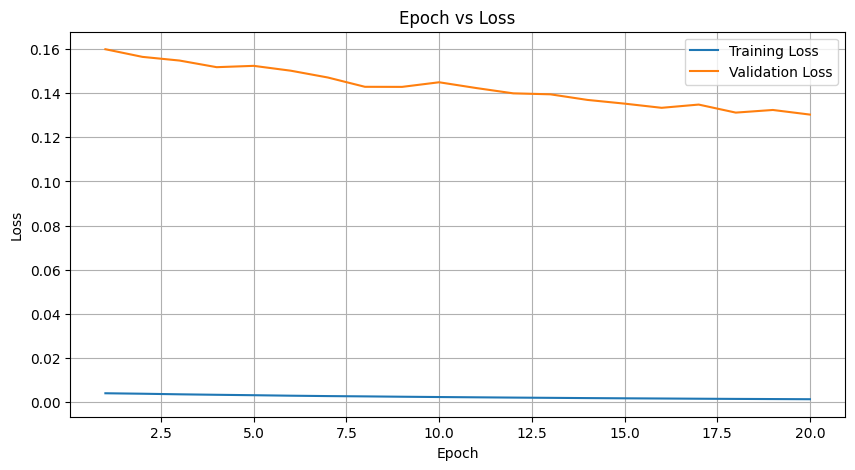

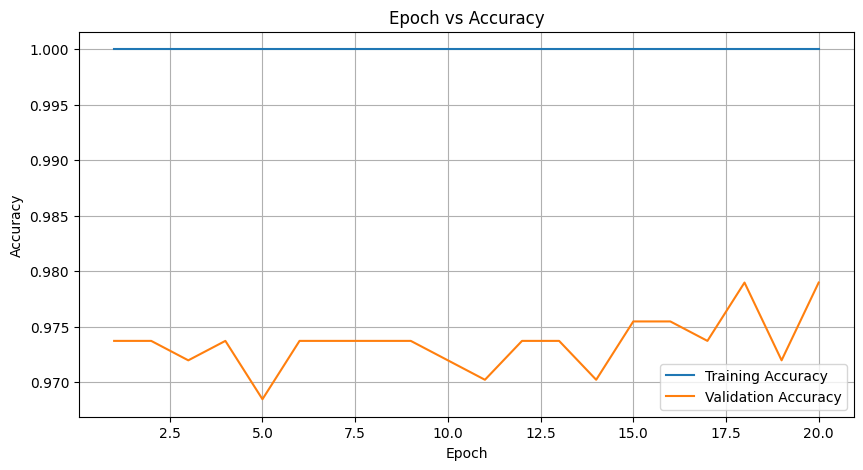

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

# Create a results dictionary from history object
results = {
    'epoch': list(range(1, len(history.history['accuracy']) + 1)),
    'accuracy': history.history['accuracy'],
    'val_accuracy': history.history['val_accuracy'],
    'loss': history.history['loss'],
    'val_loss': history.history['val_loss'],
    'learning_rate': [float(tf.keras.backend.get_value(model.optimizer.learning_rate))] * len(history.history['accuracy'])
}

# Create a DataFrame
results_df = pd.DataFrame(results)
print(results_df)

# Save to CSV (optional)
results_df.to_csv("evaluation_results/training_metrics_table.csv", index=False)

# Plot Epoch vs. Loss
plt.figure(figsize=(10, 5))
plt.plot(results['epoch'], results['loss'], label='Training Loss')
plt.plot(results['epoch'], results['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Epoch vs Loss')
plt.legend()
plt.grid(True)
plt.savefig("evaluation_results/epoch_vs_loss.png")
plt.show()

# Plot Epoch vs. Accuracy
plt.figure(figsize=(10, 5))
plt.plot(results['epoch'], results['accuracy'], label='Training Accuracy')
plt.plot(results['epoch'], results['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Epoch vs Accuracy')
plt.legend()
plt.grid(True)
plt.savefig("evaluation_results/epoch_vs_accuracy.png")
plt.show()
